# 函数准备

In [2]:
import os
import numpy as np
import pandas as pd
import json
from copy import deepcopy
import re
import random
from random import choice

random.seed(10)

# -*- coding:utf-8 -*-


In [4]:
def evaluate(standard, prediction, fig_path):

    from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
    import numpy as np
    import matplotlib.pyplot as plt
    from itertools import cycle

    from sklearn import svm, datasets
    from sklearn.metrics import roc_curve, auc
    from sklearn.model_selection import train_test_split
    from sklearn.preprocessing import label_binarize
    from sklearn.multiclass import OneVsRestClassifier
    from scipy import interp
    from sklearn.metrics import roc_auc_score

    accuracy = accuracy_score(standard["golden"],
                            prediction["prediction"],
                            normalize=True,
                            sample_weight=None)
    precision = precision_score(standard["golden"],
                                prediction["prediction"],
                                labels=None,
                                pos_label='yes',
                                average='binary',
                                sample_weight=None,
                                zero_division='warn')
    recall = recall_score(standard["golden"],
                        prediction["prediction"],
                        labels=None,
                        pos_label='yes',
                        average='binary',
                        sample_weight=None,
                        zero_division='warn')
    f1 = f1_score(standard["golden"],
                prediction["prediction"],
                labels=None,
                pos_label='yes',
                average='binary',
                sample_weight=None,
                zero_division='warn')

    print("免疫受损:", accuracy, precision, recall, f1)

    # plot roc
    standard.loc[standard["golden"] == "yes", "golden"] = 1
    standard.loc[standard["golden"] == "no", "golden"] = 0
    standard["minus"] = 1 - standard["golden"]
    standard_v = np.array(standard.values, dtype="float")

    prediction = prediction[["rate","cut"]]
    prediction.columns = ["golden", "minus"]
    prediction_v = np.array(prediction.values, dtype="float")

    # Binarize the output
    y_test = standard_v
    y_score = prediction_v
    n_classes = y_score.shape[1]

    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    fig  = plt.figure()

    plt.plot(fpr[0], tpr[0], color='darkorange',
            lw=2, label='ROC curve (area = %0.2f)' % roc_auc[0])
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('REPEAT%s ROC curve' % re)
    plt.legend(loc="lower right")
    plt.show()
    fig.savefig("%s/roc_curve.png" % (fig_path))
            
    return accuracy, precision, recall, f1
    
def mk_dir(file_path):

    folder = os.path.exists(file_path)
    if not folder:
        os.makedirs(file_path)

# 数据集准备

In [48]:
# 判断病原菌
col_name = "是否是病原菌"
col_ab =  "pat"
cla_l = [": 是"]


In [ ]:
# 判断免疫状态
col_name = "免疫状态"
col_ab =  "immu"
cla_l = [": 是"]

In [17]:
# 判断证据等级
col_name = "证据等级"
col_ab =  "evi"
cla_l = ["1：同时具备肺组织病理+病原学证据",
        "2：肺组织病原学证据",
        "3：血及无菌体液（如脓胸液）",
        "4：气管镜活检组织培养出病原体，或者支气管肺泡灌洗液（BALF）定量培养>10**4",
        "5：气管吸出物或痰/BALF纯培养或优势培养出病原体",
        "6：气管吸出物或痰的分子诊断（PCR、基因组测序等）病原"]

que_d = {"1":"Is there lung tissue and pathogen evidence?",
        "2":"Is there pathogen evidence?",
        "3":"Is there blood or tterile body fluids evidence?",
        "4":"Is there bronchoscopy biopsy or BALF evidence?",
        "5":"Is there aspirate, sputum or BALF culture evidence?",
        "6":"Is there PCR or sequencing of aspirate, sputum evidence?"}


In [33]:
sped_path = "../5.Orgnize/文献标注-校对/"
sped_l = [ele for ele in os.listdir(sped_path) if 'add' in ele]
txt_path = "../4.Label_prepare/paper_ld_old/"

for cla in cla_l:

    train_set = {
        "data": [{
            'paragraphs': [],
            'title': "LungB"
        }],
        "version": "LungB"
    }
    train_qa = []
    im = {"yes": False, "no": True}

    for sped in sped_l:

        # 读取标注信息
        df = pd.read_excel("%s/%s" % (sped_path, sped), header=0)
        df = df.loc[df["是否是致病菌"] == "是", :]
        
        if col_name == "证据等级":
            df.loc[df[col_name] == cla, col_name] = "yes"
        else:
            df.loc[df[col_name] == cla.split("：")[0], col_name] = "yes"
        
        if "col_name" == "是否是致病菌":
            que_d = {"":'Can %s cause Pneumonia?' % df.loc[idx, "物种名称"]}
        if "col_name" == "免疫状态":
            df.loc[df[col_name] == "抑制", col_name] = "yes"
            que_d = {"":'Is patient immunosuppression?'}
        df.loc[df[col_name] != "yes", col_name] = "no"

        # 读取标题和摘要

        df["Full"] = 0

        for idx in df.index.tolist():

            with open("%s/%s/%s.txt" % (txt_path, sped.split("_")[0], df.loc[idx, "ID"]), "r") as f:
                txt = f.read()
            df.loc[idx, "Full"] = txt

            # 创建QA样本
            if df.loc[idx, col_name] in ['yes', 'no']:

                # im = (df.loc[idx, "是否是致病菌"] != 'yes')
                qa = {
                    'qas': [{
                        'id': '%s:%s' % (df.loc[idx, "ID"], df.loc[idx, "物种名称"]),
                        'question': que_d[cla.split("：")[0]],
                        'is_impossible': im[df.loc[idx, col_name]],
                        'answers': '%s' % df.loc[idx, col_name]
                    }],
                    'context':
                    '%s' % df.loc[idx, "Full"]
                }
                train_qa.append(qa)
        
        mk_dir("input/input_%s_yn%s" % (col_ab, cla.split("：")[0]))
        df.to_csv("input/input_%s_yn%s/%s.csv" %
                  (col_ab, cla.split("：")[0], sped.split("_")[0]), header=True, index=False)

    train_set['data'][0]["paragraphs"] = train_qa
    json.dump(train_set, open("input/input_%s_yn%s/train_set.json" %
              (col_ab, cla.split("：")[0]), "w"))


# 预测

In [25]:
prediction = json.load(open("output/output_pat/predictions_.json", 'r'))
result = {}
for i in prediction.keys():
    toke = i.split(":")[0]
    species = ""
    for j in toke.split("_")[0:-1]:
        species = species + " " + j
    ncbi = "https://pubmed.ncbi.nlm.nih.gov/%s/" % toke.split("_")[-1]

    result[toke] = [toke.split("_")[-1], species, prediction[i][1][0], ncbi]

result = pd.DataFrame(result, index=["ID", "SPECIES", "rate", "link"]).T
sped_path = "../4.Label_prepare/paper_md"
sped_l = [ele for ele in os.listdir(sped_path) if '.' not in ele]

for cla in cla_l:

    test_set = {"data": [{'paragraphs': [], 'title':"LungB"}], "version": "LungB"}
    test_qa = []

    for sped in sped_l:

        df = pd.DataFrame(np.zeros((0, 2)), columns=["SPECIES", "Full"])

        id_l = [ele for ele in os.listdir(
            "%s/%s" % (sped_path, sped))if 'txt' in ele]
        id_l = [ele for ele in id_l if ele.replace(".txt", "") in result.index]

        for idx in id_l:
            
            if result.loc[idx.replace(".txt", ""), "rate"] > 0.5:

                with open("%s/%s/%s" % (sped_path, sped, idx)) as f:
                    txt0 = f.readlines()
                with open("%s/%s/%s" % (sped_path, sped, idx)) as f:
                    txt = f.read()

                idx = idx.split(".")[0]
                df.loc[idx] = [txt0[0].split(":")[1], txt]

                qa = {'qas': [{
                    'id': '%s:%s' % (idx, df.loc[idx, "SPECIES"]),
                    'question': que_d[cla.split("：")[0]]}],
                    'context': '%s' % df.loc[idx, "Full"]}
                test_qa.append(qa)
        
        mk_dir("input/input_%s_yn%s" % (col_ab, cla.split("：")[0]))
        df.to_csv("input/input_%s_yn%s/%s.csv" %
                  (col_ab, cla.split("：")[0], sped), header=True, index=True)

    test_set['data'][0]["paragraphs"] = test_qa
    json.dump(test_set, open("input/input_%s_yn%s/test_set.json" % (col_ab, cla.split("：")[0]), "w"))


In [ ]:
for i in cla_l:
    prediction = json.load(open("output/output_%s_yn%s/predictions_.json" % (col_ab, i.split("：")[0].split("：")[0].split("：")[0]), 'r'))
    result = {}
    for i in prediction.keys():
        toke = i.split(":")[0]
        species = ""
        for j in toke.split("_")[0:-1]:
            species = species + " " + j
        ncbi = "https://pubmed.ncbi.nlm.nih.gov/%s/" % toke.split("_")[-1]

        result[toke] = [toke.split("_")[-1], species, prediction[i][1][0], ncbi]
        
    result = pd.DataFrame(result, index = ["ID", "SPECIES", "rate", "link"]).T
    result = result.loc[result["rate"]>0.95, :]
    result.to_csv("output/prediction.csv", header=True, index=True)

# 验证

In [34]:
col_ab = "evi"
for cla in cla_l:

    train_set = json.load(open("input/input_%s_yn%s/train_set.json" \
        %(col_ab, cla.split("：")[0]), "r"))
    train_qa = train_set['data'][0]["paragraphs"]
    
    for re in range(3):

        eval_qa = random.sample(train_qa, int(len(train_qa) / 5))

        ttrain_qa = [ele for ele in train_qa if ele not in eval_qa]
        ttrain_set = {
            "data": [{
                'paragraphs': ttrain_qa,
                'title': "LungB"
            }],
            "version": "LungB"
        }

        # mk_dir("eval/evl_%s_yn" % (col_ab, cla.split("：")[0]))
        # mk_dir("eval/evl_%s_yn%s/input%s" % (col_ab, cla.split("：")[0], re))
        # mk_dir("eval/evl_%s_yn%s/output%s" % (col_ab, cla.split("：")[0], re))

        json.dump(ttrain_set, open("eval/evl_%s_yn%s/input%s/train_set.json" 
        % (col_ab, cla.split("：")[0], re), "w"))

        eval_q=[]
        eval_a={}
        for i in eval_qa:
            qq={
                'qas': [{
                    'id': i['qas'][0]['id'],
                    'question': i['qas'][0]['question']
                }],
                'context': i['context']
            }
            eval_q.append(qq)
            eval_a[i['qas'][0]['id']] = i['qas'][0]['answers']

        eval_qset = {
            "data": [{
                'paragraphs': eval_q,
                'title': "LungB"
            }],
            "version": "LungB"
        }
        json.dump(eval_qset, open("eval/evl_%s_yn%s/input%s/test_set.json" 
        % (col_ab, cla.split("：")[0], re), "w"))
        json.dump(eval_a, open("eval/evl_%s_yn%s/input%s/eval_set.json" 
        % (col_ab, cla.split("：")[0], re), "w"))


免疫受损: 0.5925925925925926 0.41379310344827586 0.7058823529411765 0.5217391304347826


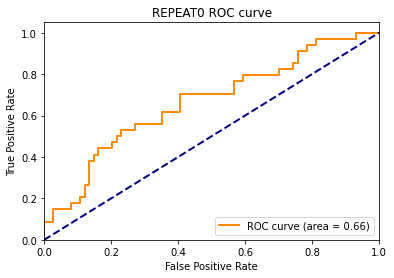

免疫受损: 0.5555555555555556 0.2833333333333333 0.7727272727272727 0.4146341463414634


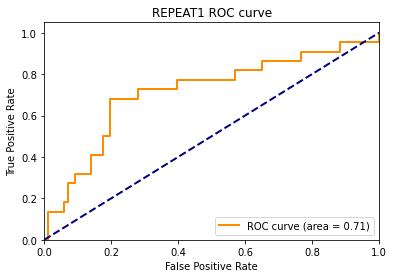

免疫受损: 0.75 0.42857142857142855 0.6818181818181818 0.5263157894736843


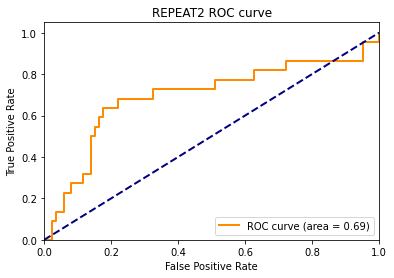

免疫受损: 0.6388888888888888 0.4716981132075472 0.6944444444444444 0.5617977528089889


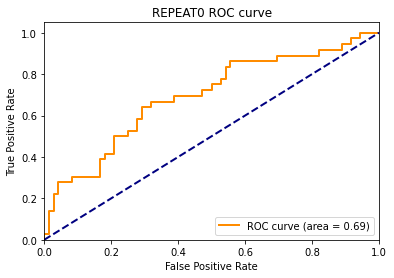

免疫受损: 0.6481481481481481 0.0 0.0 0.0


C:\Users\xinzhuo\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


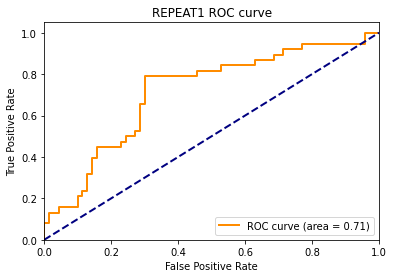

免疫受损: 0.7009345794392523 0.3333333333333333 0.45454545454545453 0.3846153846153846


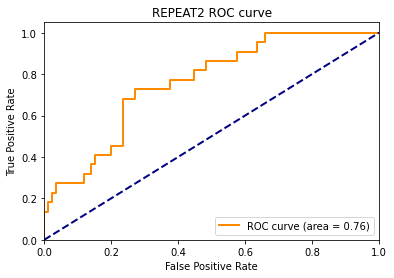

免疫受损: 0.7592592592592593 0.48 0.48 0.48


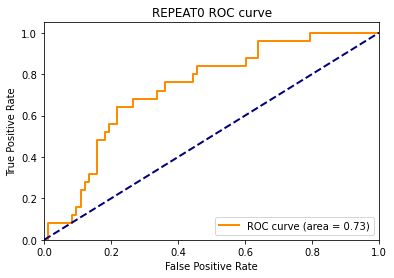

免疫受损: 0.6018518518518519 0.35185185185185186 0.7037037037037037 0.46913580246913583


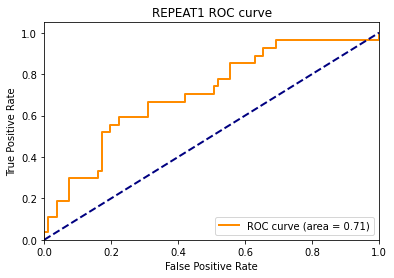

C:\Users\xinzhuo\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


免疫受损: 0.7037037037037037 0.0 0.0 0.0


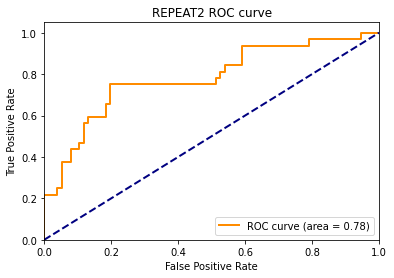

免疫受损: 0.6944444444444444 0.0 0.0 0.0


C:\Users\xinzhuo\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


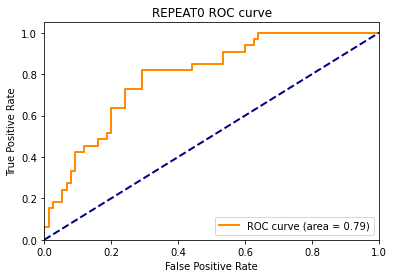

免疫受损: 0.7075471698113207 0.0 0.0 0.0


C:\Users\xinzhuo\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


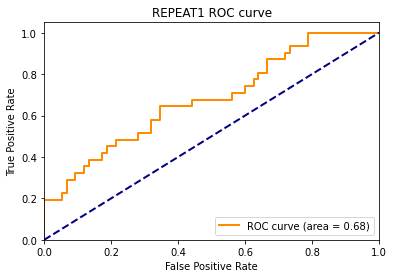

免疫受损: 0.6296296296296297 0.4 0.8571428571428571 0.5454545454545455


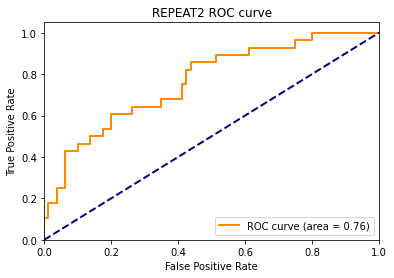

免疫受损: 0.6574074074074074 0.45454545454545453 0.78125 0.5747126436781609


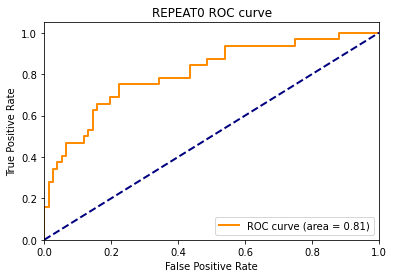

免疫受损: 0.7037037037037037 0.3783783783783784 0.6086956521739131 0.4666666666666667


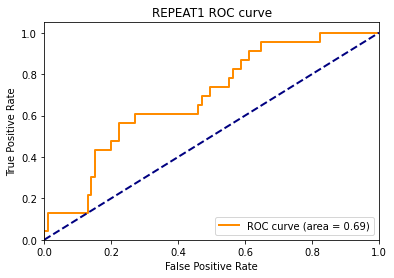

免疫受损: 0.7314814814814815 0.4074074074074074 0.4583333333333333 0.4313725490196078


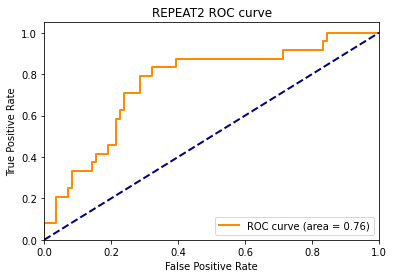

免疫受损: 0.6481481481481481 0.4 0.7142857142857143 0.5128205128205129


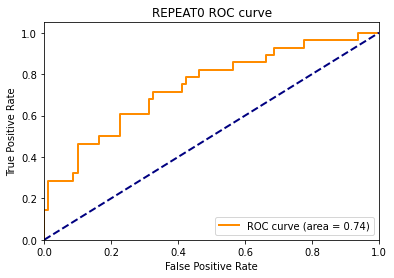

免疫受损: 0.6666666666666666 0.42857142857142855 0.7241379310344828 0.5384615384615385


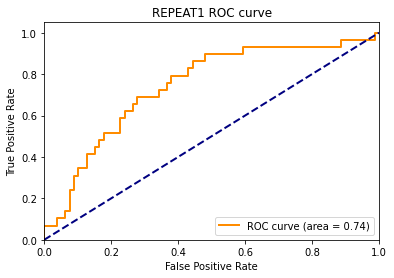

免疫受损: 0.8240740740740741 0.8571428571428571 0.25 0.3870967741935483


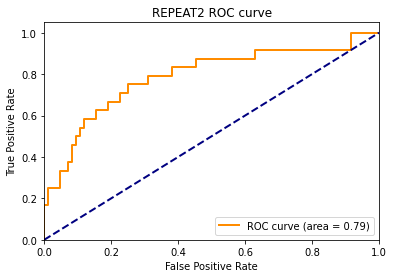

In [54]:
for i in cla_l:
    for re in range(3):
        eval_a = json.load(open("eval/evl_%s_yn%s/input%s/eval_set.json" % (col_ab, i.split("：")[0], re), "r"))
        standard = pd.DataFrame(eval_a, index=["golden"]).T
        prediction = json.load(open("eval/evl_%s_yn%s/output%s/predictions_.json" 
        % (col_ab, i.split("：")[0], re), 'r'))
        prediction = pd.DataFrame(prediction, index=["prediction", "rate"]).T
        prediction["cut"] = 1
        for idx in prediction.index:
            prediction.loc[idx, "rate"] = prediction.loc[idx, "rate"][0]
            prediction.loc[idx, "cut"] = 1 - prediction.loc[idx, "rate"]

            if prediction.loc[idx, "rate"] < 0.95:
                prediction.loc[idx, "prediction"] = "no"
        fig_path = ("eval/evl_%s_yn%s/output%s" % (col_ab, i.split("：")[0], re))

        evaluate(standard, prediction, fig_path)


# 组织

In [ ]:
sped_l = os.listdir("../4.Label_prepare/paper_md/")
for sped in sped_l:
    spec_l = os.listdir("../4.Label_prepare/paper_md/%s" % sped)
    spec_l = [spec.replace(".txt", "") for spec in spec_l]
    spec_tl = [spec for spec in result.index if spec in spec_l]
    spec_yl = [spec for spec in a.index if spec in spec_l]
#     print(sped, len(np.unique(spec_tl)), len(np.unique(spec_yl)))
    specc_tl = [spec.split("_")[0:-1] for spec in spec_tl]
    specc_yl = [spec.split("_")[0:-1] for spec in spec_yl]
    print(sped, len(np.unique(specc_tl)), len(np.unique(specc_yl)))

In [ ]:
b = a["SPECIES"]

c = []
for i in b:
    spec = ""
    for j in i:
        spec = spec + " " + j
        print(spec)
        c.append(spec)
a["SPECIES"] = c.append(spec)